In [2]:
import numpy as np
import sorting
import time
from matplotlib import pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer
from scipy.optimize import curve_fit


np.random.seed(42)


In [4]:
MIN_MERGE = 32


def calcMinRun(n):
    """Returns the minimum length of a
    run from 23 - 64 so that
    the len(array)/minrun is less than or
    equal to a power of 2.

    e.g. 1=>1, ..., 63=>63, 64=>32, 65=>33,
    ..., 127=>64, 128=>32, ...
    """
    r = 0
    while n >= MIN_MERGE:
        r |= n & 1
        n >>= 1
    return n + r


# This function sorts array from left index to
# to right index which is of size atmost RUN
def insertionSort(arr, left, right):
    for i in range(left + 1, right + 1):
        j = i
        while j > left and arr[j] < arr[j - 1]:
            arr[j], arr[j - 1] = arr[j - 1], arr[j]
            j -= 1


# Merge function merges the sorted runs
def merge(arr, l, m, r):

    # original array is broken in two parts
    # left and right array
    len1, len2 = m - l + 1, r - m
    left, right = [], []
    for i in range(0, len1):
        left.append(arr[l + i])
    for i in range(0, len2):
        right.append(arr[m + 1 + i])

    i, j, k = 0, 0, l

    # after comparing, we merge those two array
    # in larger sub array
    while i < len1 and j < len2:
        if left[i] <= right[j]:
            arr[k] = left[i]
            i += 1

        else:
            arr[k] = right[j]
            j += 1

        k += 1

    # Copy remaining elements of left, if any
    while i < len1:
        arr[k] = left[i]
        k += 1
        i += 1

    # Copy remaining element of right, if any
    while j < len2:
        arr[k] = right[j]
        k += 1
        j += 1


# Iterative Timsort function to sort the
# array[0...n-1] (similar to merge sort)
def timSort(arr):
    n = len(arr)
    minRun = calcMinRun(n)

    # Sort individual subarrays of size RUN
    for start in range(0, n, minRun):
        end = min(start + minRun - 1, n - 1)
        insertionSort(arr, start, end)

    # Start merging from size RUN (or 32). It will merge
    # to form size 64, then 128, 256 and so on ....
    size = minRun
    while size < n:

        # Pick starting point of left sub array. We
        # are going to merge arr[left..left+size-1]
        # and arr[left+size, left+2*size-1]
        # After every merge, we increase left by 2*size
        for left in range(0, n, 2 * size):

            # Find ending point of left sub array
            # mid+1 is starting point of right sub array
            mid = min(n - 1, left + size - 1)
            right = min((left + 2 * size - 1), (n - 1))

            # Merge sub array arr[left.....mid] &
            # arr[mid+1....right]
            if mid < right:
                merge(arr, left, mid, right)

        size = 2 * size


In [34]:
def const_func(v):
    return 42


def sum_func(v):
    res = 0
    for i in v:
        res += i
    return res


def prod_func(v):
    res = 1
    for i in v:
        res *= i
    return res


def poly_func(v, x=1.5):
    import decimal
    decimal.getcontext().prec = 100
    res = 0
    for i in range(len(v)):
        res += decimal.Decimal(v[i]) * (decimal.Decimal(x) ** i)
    return res


def poly_func_horner(v, x=1.5):
    res = x
    for i in range(len(v)-1, 0, -1):
        res = res * v[i] + v[i-1]
    return res


def timsort(v):
    # since standard library's sorted is too fast, use custom implementation from
    # https://www.geeksforgeeks.org/timsort/
    timSort(v)


def bubblesort(v):
    for i in range(len(v)-1):
        for j in range(0, len(v)-i-1):
            if v[j] > v[j + 1]:
                v[j], v[j + 1] = v[j + 1], v[j]
    return v


def quicksort(v):
    return sorting.quick(v)

def matrix_mult(a, b):
    m = len(a)
    n = len(a[0])
    assert n == len(b)
    k = len(b[0])
    res = np.zeros((m, k))
    for i in range(m):
        for j in range(k):
            total = 0
            for l in range(n):
                total += a[i][l] * b[l][j]
            res[i][j] = total
    return res


In [6]:
# estimator functions for theoretical complexity
def const_est(x, a):
    return np.ones_like(x) * a


def linear_est(x, a):
    return a*x


def nlogn_est(x, a):
    return a*x*np.log(x)


def quad_est(x, a):
    return a*x**2


def cubic_est(x, a):
    return a*x**3


In [37]:
def plot_times(avg_time, est_func, experiment_title):
    if est_func == nlogn_est:
        xdata = np.linspace(1, len(avg_time), len(avg_time)-1, dtype=np.float64)
        ydata = np.array(avg_time, dtype=np.float64)
        popt, _ = curve_fit(est_func, xdata, ydata[1:])
    else:
        xdata = np.arange(len(avg_time), dtype=np.float64)
        ydata = np.array(avg_time, dtype=np.float64)
        popt, _ = curve_fit(est_func, xdata, ydata)
    plt.plot(avg_time)
    plt.title(f"Time measurement for {experiment_title}")
    plt.grid(True)
    plt.plot(xdata, est_func(xdata, *popt), 'r-',
             label='fit: a=%5.3f, ' % tuple(popt))
    plt.legend(["Experimental", "Theoretical"])
    plt.show()


In [ ]:
def measure_time(n_runs, n_experiments, func, matrix=False):
    times = []
    for i in range(n_runs):
        times.append([])
        for j in tqdm(range(1, n_experiments + 1)):
            if matrix:
                matrix_a = np.random.rand(j, j)
                matrix_b = np.random.rand(j, j)
                start_time = timer()
                func(matrix_a, matrix_b)
                times[i].append(timer() - start_time)
            else:
                v = np.random.rand(j)
                start_time = timer()
                func(v)
                times[i].append(timer() - start_time)
            
    return np.array(times, dtype=np.float64).mean(axis=0)


100%|██████████| 2000/2000 [00:00<00:00, 142891.83it/s]


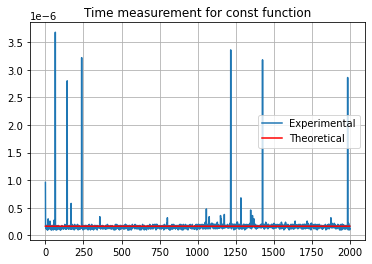

In [45]:
avg_time = measure_time(5, 2000, const_func)
plot_times(avg_time, const_est, "const function")

100%|██████████| 2000/2000 [00:00<00:00, 12121.14it/s]


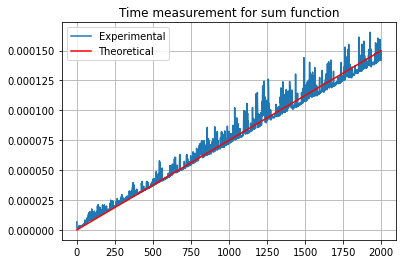

In [44]:
avg_time = measure_time(5, 2000, sum_func)
plot_times(avg_time, linear_est, "sum function")


100%|██████████| 2000/2000 [00:00<00:00, 11299.33it/s]


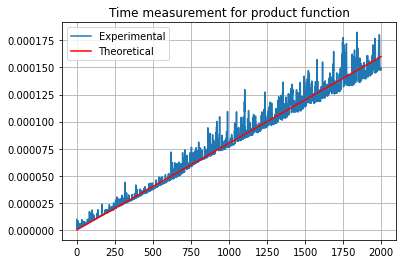

In [43]:
avg_time = measure_time(5, 2000, prod_func)
plot_times(avg_time, linear_est, "product function")

100%|██████████| 2000/2000 [00:06<00:00, 294.64it/s]


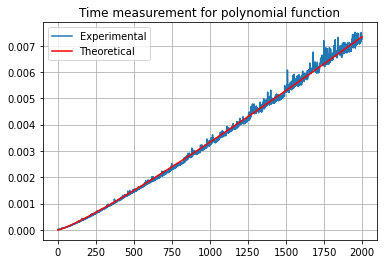

In [47]:
avg_time = measure_time(5, 2000, poly_func)
plot_times(avg_time, nlogn_est, "polynomial function")


100%|██████████| 2000/2000 [00:00<00:00, 3656.32it/s]


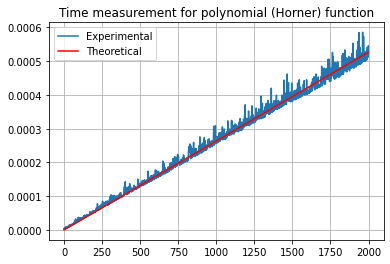

In [41]:
avg_time = measure_time(5, 2000, poly_func_horner)
plot_times(avg_time, linear_est, "polynomial (Horner) function")


100%|██████████| 2000/2000 [00:09<00:00, 216.17it/s]


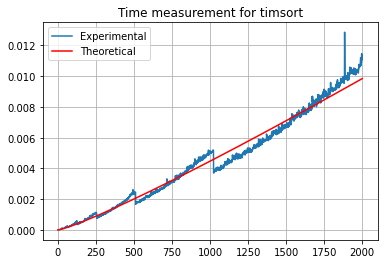

In [40]:
avg_time = measure_time(5, 2000, timsort)
plot_times(avg_time, nlogn_est, "timsort")


100%|██████████| 800/800 [00:24<00:00, 32.15it/s]


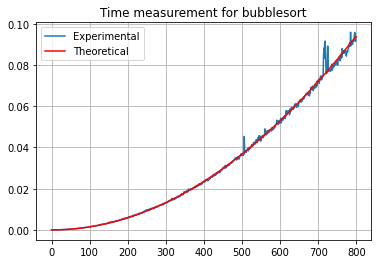

In [39]:
avg_time = measure_time(5, 800, bubblesort)
plot_times(avg_time, quad_est, "bubblesort")


100%|██████████| 2000/2000 [00:07<00:00, 267.13it/s]


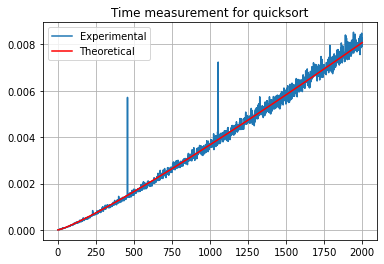

In [38]:
avg_time = measure_time(5, 2000, quicksort)
plot_times(avg_time, nlogn_est, "quicksort")

100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


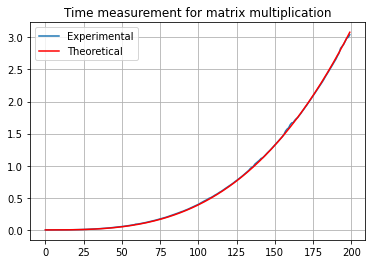

In [35]:
avg_time = measure_time(5, 200, matrix_mult, matrix=True)
plot_times(avg_time, cubic_est , "matrix multiplication")
